### 1. Extracción y preparación de datos

In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

# Cargar datos
data = pd.read_csv("../datasets_limpios/credit_data_clean.csv")

# Separar variables predictoras y target
X = data.drop(columns=["target"])
y = data["target"]

# Identificar columnas categóricas
cat_cols = X.select_dtypes(include=['object']).columns

# Codificar categóricas con OrdinalEncoder
if len(cat_cols) > 0:
    encoder = OrdinalEncoder()
    X[cat_cols] = encoder.fit_transform(X[cat_cols])

print("✅ Datos preparados para entrenamiento")


✅ Datos preparados para entrenamiento


### 2. Entrenamiento del modelo ensemble (Random Forest)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Dividir en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Entrenar el modelo ensemble
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    random_state=42,
    class_weight='balanced_subsample'
)
rf_model.fit(X_train, y_train)

print("✅ Modelo Random Forest entrenado correctamente")


✅ Modelo Random Forest entrenado correctamente


### 3. Interpretación: importancia de variables

In [3]:
import numpy as np

importances = rf_model.feature_importances_
features = X.columns

imp_df = pd.DataFrame({
    "Variable": features,
    "Importancia": importances
}).sort_values(by="Importancia", ascending=False)

print("📈 Importancia de las variables:")
display(imp_df.head(10))


📈 Importancia de las variables:


,Variable,Importancia
0,checking_account_status,0.186412
1,duration_months,0.112308
4,credit_amount,0.108787
5,savings_account,0.091912
12,age,0.079963
2,credit_history,0.066465
3,purpose,0.049070
11,property,0.042193
6,employment_since,0.041583
7,installment_rate,0.029222


### 4. “Extracción de reglas” (versión interpretativa para ensemble)

/home/superiorluis/.local/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


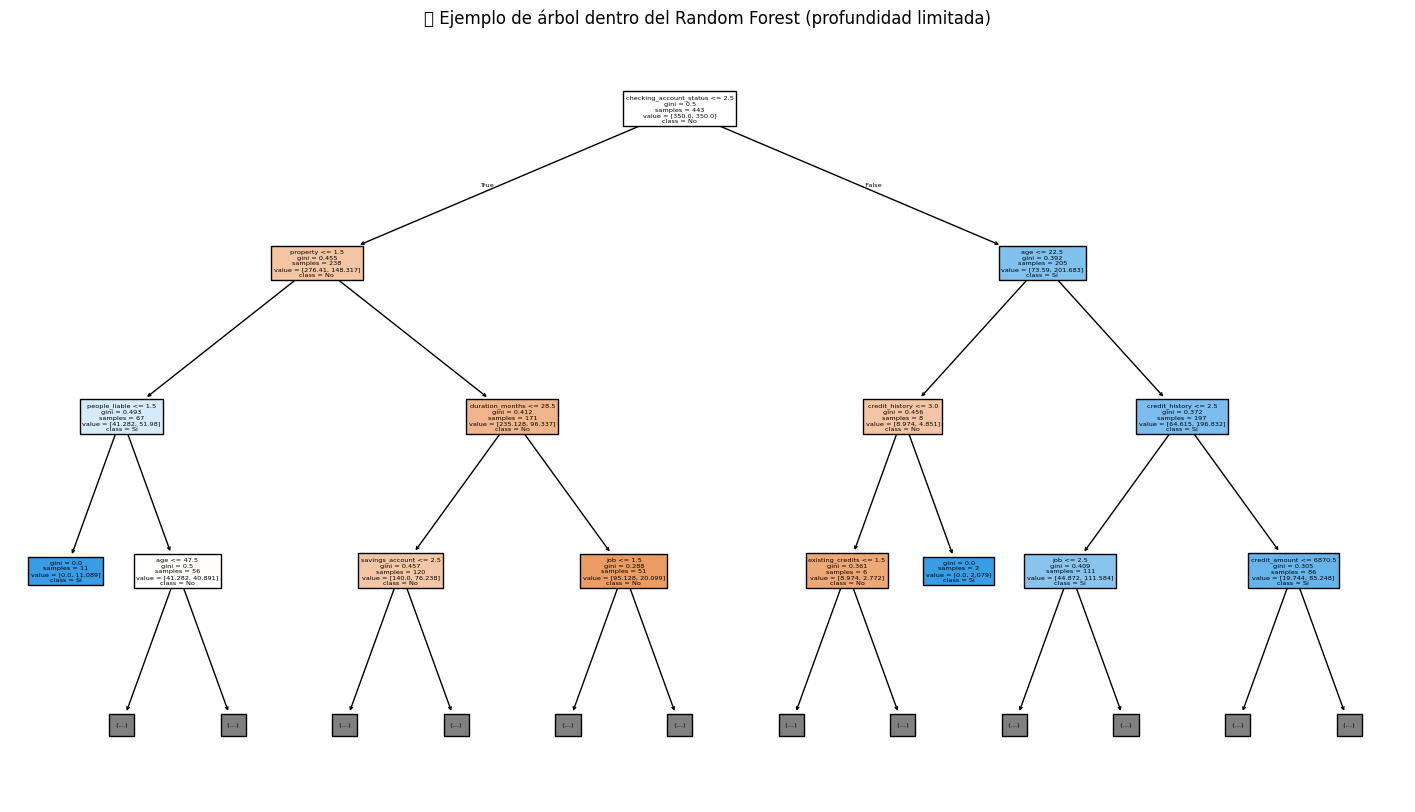

In [4]:
from sklearn import tree
import matplotlib.pyplot as plt

plt.figure(figsize=(18,10))
tree.plot_tree(
    rf_model.estimators_[0],
    feature_names=X.columns,
    class_names=["No", "Sí"],
    filled=True,
    max_depth=3
)
plt.title("🌳 Ejemplo de árbol dentro del Random Forest (profundidad limitada)")
plt.show()


### 5. Evaluación completa del modelo ensemble

📊 MÉTRICAS DEL MODELO (Random Forest)
Accuracy:   0.773
Precision:  0.851
Recall:     0.819
F1-score:   0.835
ROC-AUC:    0.804
PR-AUC:     0.894

🧩 Matriz de confusión:
[[ 60  30]
 [ 38 172]]


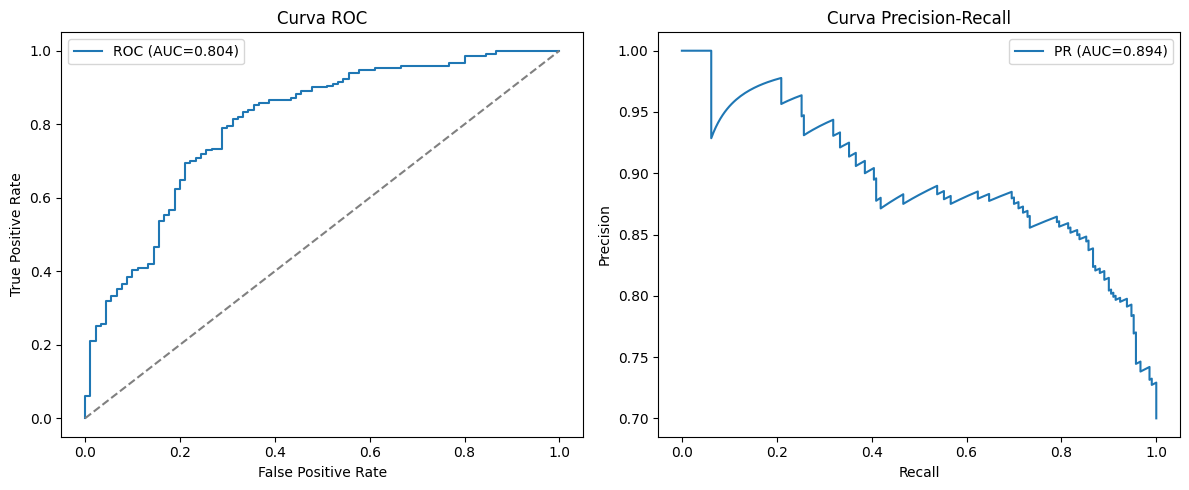

In [5]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, confusion_matrix, precision_recall_curve
)

# Predicciones
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Métricas principales
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
precisions, recalls, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recalls, precisions)

print("📊 MÉTRICAS DEL MODELO (Random Forest)")
print(f"Accuracy:   {acc:.3f}")
print(f"Precision:  {prec:.3f}")
print(f"Recall:     {rec:.3f}")
print(f"F1-score:   {f1:.3f}")
print(f"ROC-AUC:    {roc_auc:.3f}")
print(f"PR-AUC:     {pr_auc:.3f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
print("\n🧩 Matriz de confusión:")
print(cm)

# Curvas ROC y PR
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()

plt.subplot(1,2,2)
plt.plot(recalls, precisions, label=f"PR (AUC={pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.legend()

plt.tight_layout()
plt.show()


### 6. Análisis de estabilidad, robustez y sensibilidad

- Estabilidad:
  El Random Forest reduce la varianza de los árboles individuales promediando muchos modelos.
  Es altamente estable ante pequeñas variaciones en los datos y menos propenso al sobreajuste
  que un árbol de decisión simple.

- Robustez ante desbalance:
  Con class_weight='balanced_subsample', el modelo ajusta el peso de las clases en cada árbol.
  Esto lo hace más robusto frente a clases desbalanceadas que la regresión logística o un árbol único.

- Sensibilidad al umbral:
  Aunque el modelo produce probabilidades, el umbral de 0.5 sigue afectando
  el trade-off entre precisión y recall. Las curvas ROC y PR permiten ajustar ese punto óptimo.

- Interpretabilidad:
  Es menos interpretable que un árbol o una regresión logística, pero las importancias de variables
  permiten identificar qué factores influyen más en las decisiones del modelo.

In [7]:
import joblib
import os

os.makedirs("modelos_guardados", exist_ok=True)

modelo_nombre = "random_forest_model.pkl"  # Cambia por: "arbol_decision.pkl", "log_reg.pkl", "red_neuronal.pkl", etc.

joblib.dump(rf_model, f"modelos_guardados/{modelo_nombre}")

print(f"✅ Modelo guardado correctamente en: modelos_guardados/{modelo_nombre}")


✅ Modelo guardado correctamente en: modelos_guardados/random_forest_model.pkl
